In [1]:
versioninfo()

Julia Version 1.10.0
Commit 3120989f39 (2023-12-25 18:01 UTC)
Build Info:
  Official https://julialang.org/ release
Platform Info:
  OS: Windows (x86_64-w64-mingw32)
  CPU: 6 × Intel(R) Core(TM) i5-9600K CPU @ 3.70GHz
  WORD_SIZE: 64
  LIBM: libopenlibm
  LLVM: libLLVM-15.0.7 (ORCJIT, skylake)
  Threads: 2 on 6 virtual cores
Environment:
  JULIA_PYTHONCALL_EXE = python


In [2]:
using LinearAlgebra
using DelimitedFiles
using PyPlot
using SparseArrays
using ProgressMeter

In [3]:
BLAS.set_num_threads(6)

In [4]:
rcParams = PyPlot.PyDict(PyPlot.matplotlib."rcParams")
rcParams["font.size"] = 8
rcParams["axes.titlesize"] = 8

8

In [5]:
mkpath("matrix")
mkpath("fig")

"fig"

In [6]:
; FreeFem++ cd.edp

-- FreeFem++ v4.11 (Thu, Apr 07, 2022  2:25:37 PM - git v4.11)
   file : cd.edp
 Load: lg_fem lg_mesh lg_mesh3 eigenvalue 
    1 : mesh Th = square(19,19); // generate mesh
    2 : fespace Vh(Th, P1); // generate finite element space
    3 : Vh u, v;
    4 : varf m(u,v) = int2d(Th)(u*v)+ on(1,2,3,4, u=0);
    5 : // generate matrix M
    6 : matrix M = m(Vh, Vh);
    7 : {
    8 :     ofstream file("matrix/M_ff.txt");
    9 :     file << M << endl;
   10 : }
   11 : 
   12 : // generate matrix K
   13 : real[int] alpha = [0.001, 0.001, 0.01, 0.01];
   14 : real[int] beta = [0.2, 0.4, 0.2, 0.4];
   15 : 
   16 : for (int i=0; i<4; i++){
   17 :     varf k(u,v) = - int2d(Th)(alpha[i]*(dx(u)*dx(v) + dy(u)*dy(v)))
   18 :             + int2d(Th)(beta[i]*(dx(u)*v + dy(u)*v))
   19 :             + on(1,2,3,4, u=0);
   20 :     matrix K = k(Vh, Vh);
   21 :     {
   22 :         ofstream file("matrix/K" + i + "_ff.txt");
   23 :         file << K << endl;
   24 :     }
   25 : } sizestack + 1

In [7]:
function freefem_matrix_to_sparse(filename::String)
    i, j, v = zeros(Int, 0), zeros(Int, 0), zeros(0)
    n, m, nnz = 0, 0, 0
    for (k, line) in enumerate(eachline(filename))
        if k == 3
            l = split(line)
            n, m, nnz = parse(Int, l[1]), parse(Int, l[2]), parse(Int, l[3])
            i, j, v = zeros(Int, nnz), zeros(Int, nnz), zeros(nnz)
        elseif k >= 4
            l = split(line)
            if length(l) == 3
                i[k-3] = parse(Int, string(l[1])) + 1
                j[k-3] = parse(Int, string(l[2])) + 1
                v[k-3] = parse(Float64, string(l[3]))
            end
        end
    end
    return sparse(i, j, v, n, m)
end


function remove_tgvrc(A::AbstractMatrix)
    n = size(A,1)
    idx = [] # indices to be removed
    for i = 1:n
        if A[i,i] > 1e17
            append!(idx, i)
        end
    end
    return A[1:n .∉ [idx], 1:n .∉ [idx]]
end

# convert matrices for the experiment
for matname in ["M", "K0", "K1", "K2", "K3"]
    filename_ff = "matrix/$(matname)_ff.txt"
    filename_out = "matrix/$(matname).txt"
    A = freefem_matrix_to_sparse(filename_ff)
    writedlm(filename_out, remove_tgvrc(A))
end

sys:1: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


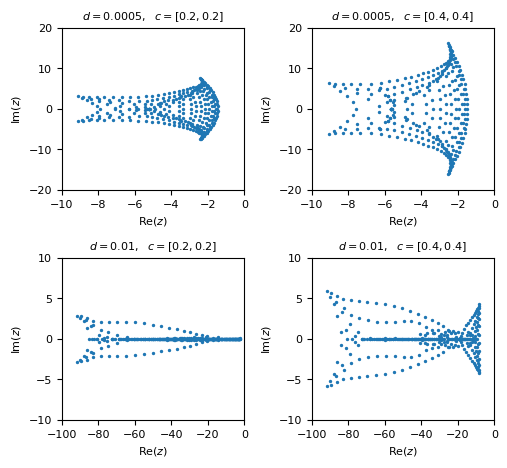

In [8]:
fig, ax = subplots(2, 2, figsize=[13/2.54, 12/2.54])

α_list = [0.0005, 0.0005, 0.01, 0.01]
β_list = [0.2, 0.4, 0.2, 0.4]

for k = 0:3
    i = k ÷ 2 + 1
    j = k % 2 + 1
    α = α_list[k+1]
    β = β_list[k+1]
    M = readdlm("matrix/M.txt")
    K = readdlm("matrix/K$(k).txt")
    λ = eigvals(K, M)

    ax[i,j].scatter(real(λ), imag(λ), s=2)
    ax[i,j].set_xlabel("\$\\mathrm{Re}(z)\$")
    ax[i,j].set_ylabel("\$\\mathrm{Im}(z)\$")
    ax[i,j].set_title("\$d = $(α), ~~ c = [$(β),$(β)]\$")
    if i == 1
        ax[i,j].set_xlim(-10, 0)
        ax[i,j].set_ylim(-20, 20)
    else
        ax[i,j].set_xlim(-100, 0)
        ax[i,j].set_ylim(-10, 10)
    end
end

fig.tight_layout()
fig.savefig("fig/test4_eigvals.pdf")
show()

In [9]:
include("expm_pade1313.jl")
M_f64 = readdlm("matrix/M.txt")
M = convert(Matrix{BigFloat}, M_f64)
for i = 0:3
    K = convert(Matrix{BigFloat}, readdlm("matrix/K$(i).txt"))
    X = expm_pade1313(M \ K)
    writedlm("matrix/test4_Ref_$(i).txt", convert(Matrix{Float64}, X))
end

In [6]:
include("expm_talbot.jl")

results_talbot = Dict()
m_max_list = [340, 540, 180, 300]
l = 21
for i = 0:3
    m_max = m_max_list[i+1]
    m_stepsize = min(m_max ÷ (l-1), 8)
    M = readdlm("matrix/M.txt")
    K = readdlm("matrix/K$(i).txt")
    Ref = readdlm("matrix/test4_Ref_$(i).txt")
    result = expm_talbot(K, m_stepsize, m_max, eps(), B=M, Ref=Ref)
    m_list = result.errors |> keys |> collect |> sort
    err_list = [result.errors[m] for m in m_list]
    results_talbot[i] = Dict(:m => m_list, :err => err_list)
    m_max = maximum(keys(result.estimates))
    @show i, result.estimates[m_max]
    flush(stdout)
end

(i, result.estimates[m_max]) = (0, 8.410973569078612e-9)
(i, result.estimates[m_max]) = (1, 0.40083021672515673)
(i, result.estimates[m_max]) = (2, 3.0434044172497576e-14)
(i, result.estimates[m_max]) = (3, 1.786059707733872e-14)


In [7]:
include("expm_de.jl")

results_de = Dict()
h_inv_max = [30, 50, 15, 30]

l = 21
for k = 0:3
    err_list = zeros(l)
    m_list = zeros(Int,l)
    M = readdlm("matrix/M.txt")
    K = readdlm("matrix/K$(k).txt")
    λ_right = maximum(real(eigvals(K, M)))
    Ref = readdlm("matrix/test4_Ref_$(k).txt")
    h_inv_list = LinRange(h_inv_max[k+1]÷10, h_inv_max[k+1], l)
    @showprogress for (i, h_inv) in enumerate(h_inv_list)
        h = 1 / h_inv
        result = expm_de(K, h, B=M, λ_right=λ_right, σ=-2.5, ϵ=eps())
        X = result.X
        m = result.r[1] - result.l[1] + 1
        err = opnorm(X - Ref)
        m_list[i] = m
        err_list[i] = err
    end
    @show k, err_list[end]
    results_de[k] = Dict(:m => m_list, :err => err_list)
end

Progress: 100%|█████████████████████████████████████████| Time: 0:02:42


(k, err_list[end]) = (0, 7.340520592948503e-16)


Progress: 100%|█████████████████████████████████████████| Time: 0:03:57


(k, err_list[end]) = (1, 6.647588238279445e-15)


Progress: 100%|█████████████████████████████████████████| Time: 0:01:08


(k, err_list[end]) = (2, 1.6405658854798313e-15)


Progress: 100%|█████████████████████████████████████████| Time: 0:02:14


(k, err_list[end]) = (3, 1.3321191366483776e-13)


sys:1: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


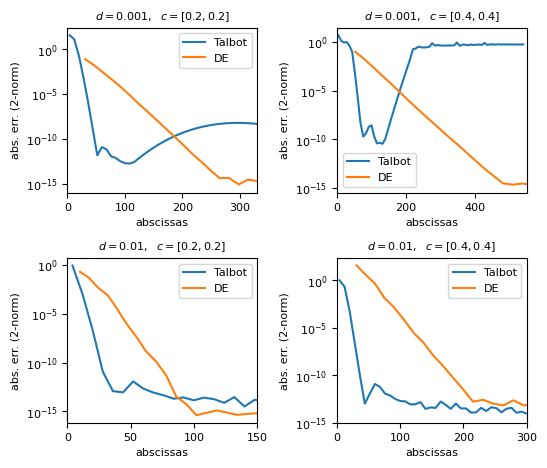

In [8]:
fig, ax = subplots(2, 2, figsize=[14/2.54, 12/2.54])

α_list = [0.001, 0.001, 0.01, 0.01]
β_list = [0.2, 0.4, 0.2, 0.4]
x_max = [330, 550, 150, 300]

for k = 0:3
    i = k ÷ 2 + 1
    j = k % 2 + 1
    α = α_list[k+1]
    β = β_list[k+1]
    x1 = results_talbot[k][:m]
    x2 = results_de[k][:m]
    y1 = results_talbot[k][:err]
    y2 = results_de[k][:err]

    ax[i,j].plot(x1, y1, label="Talbot")
    ax[i,j].plot(x2, y2, label="DE")
    ax[i,j].set_xlabel("abscissas")
    ax[i,j].set_ylabel("abs. err. (2-norm)")
    ax[i,j].legend()
    ax[i,j].set_xlim(0, x_max[k+1])
    ax[i,j].set_title("\$d = $(α), ~~ c = [$(β),$(β)]\$")
    ax[i,j].set_yscale("log")
    ax[i,j].set_yticks([1e-15,1e-10,1e-5,1e-0])
end

fig.tight_layout()
fig.savefig("fig/test4.pdf")
show()